In [1]:
#!pip install PyYAML

In [2]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader

In [3]:
# load YAML
with open('data.yaml',mode='r') as f:
    data_yaml = yaml.load(f,Loader=SafeLoader)
    
labels = data_yaml['names']
print(labels)

['person', 'car', 'chair', 'bottle', 'pottedplant', 'bird', 'dog', 'sofa', 'bicycle', 'horse', 'boat', 'motorbike', 'cat', 'tvmonitor', 'cow', 'sheep', 'aeroplane', 'train', 'diningtable', 'bus']


In [4]:
# load YOLO model
yolo = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [5]:
# load the image
img = cv2.imread('./street_image.jpg')
image = img.copy()
row, col, d = image.shape


# get the YOLO prediction from the the image
# step-1 convert image into square image (array)
max_rc = max(row,col)
input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
input_image[0:row,0:col] = image
# step-2: get prediction from square array
INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WH_YOLO,INPUT_WH_YOLO),swapRB=True,crop=False)
yolo.setInput(blob)
preds = yolo.forward() # detection or prediction from YOLO

In [6]:
print(preds.shape)

(1, 25200, 25)


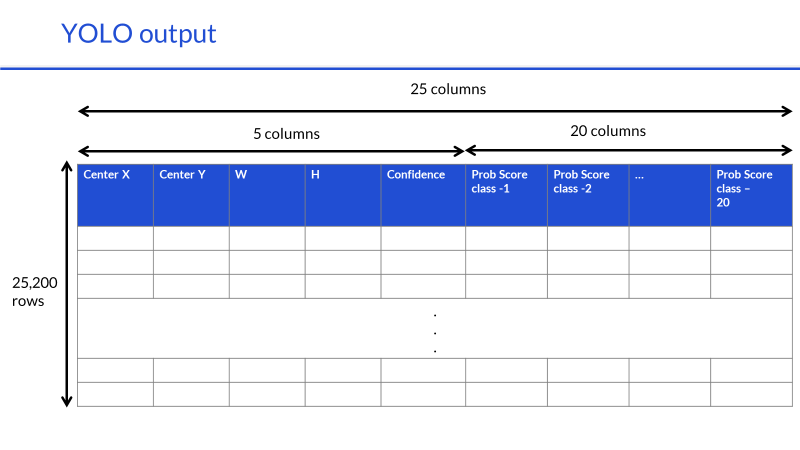

In [7]:
# Non Maximum Supression
# step-1: filter detection based on confidence (0.4) and probability score (0.25)
detections = preds[0]
boxes = []
confidences = []
classes = []

# widht and height of the image (input_image)
image_w, image_h = input_image.shape[:2]
x_factor = image_w/INPUT_WH_YOLO
y_factor = image_h/INPUT_WH_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4] # confidence of detection an object
    if confidence > 0.4:
        class_score = row[5:].max() # maximum probability from 20 objects
        class_id = row[5:].argmax() # get the index position at which max probabilty occur
        
        if class_score > 0.25:
            cx, cy, w, h = row[0:4]
            # construct bounding from four values
            # left, top, width and height
            left = int((cx - 0.5*w)*x_factor)
            top = int((cy - 0.5*h)*y_factor)
            width = int(w*x_factor)
            height = int(h*y_factor)
            
            box = np.array([left,top,width,height])
            
            # append values into the list
            confidences.append(confidence)
            boxes.append(box)
            classes.append(class_id)
            
# clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

# NMS
index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten()


In [8]:
index

array([338, 147, 162,  15, 326, 124, 291, 121, 229, 337, 300, 223, 362,
       108, 212, 221, 200,  24, 219, 322, 196,  38, 335, 313, 308, 109,
       139])

In [9]:
# Draw the Bounding
for ind in index:
    # extract bounding box
    x,y,w,h = boxes_np[ind]
    bb_conf = int(confidences_np[ind]*100)
    classes_id = classes[ind]
    class_name = labels[classes_id]
    
    text = f'{class_name}: {bb_conf}%'
    
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.rectangle(image,(x,y-30),(x+w,y),(255,255,255),-1)
    
    cv2.putText(image,text,(x,y-10),cv2.FONT_HERSHEY_PLAIN,0.7,(0,0,0),1)
    


In [10]:
cv2.imshow('original',img)
cv2.imshow('yolo_prediction',image)
cv2.waitKey(0)
cv2.destroyAllWindows()